# Job Shop Scheduling by Mathematical Programming

---

*This tutorial is adapted from the tutorial on [Google OR-Tools for job shop scheduling](https://developers.google.com/optimization/scheduling/job_shop#python)*.

The **job shop scheduling** problem is a classic AI planning, scheduling and combinatorial optimisation problem. It has many real-world applications in Industry 4.0, such as intelligent supply chain management, manufacturing and cloud computing.

In a previous [tutorial](https://github.com/meiyi1986/tutorials/blob/master/notebooks/job-shop-scheduling-state-space-search.ipynb), we have introduced how to solve job shop scheduling from AI planning perspective. Specifically, we define the **environment**, **state**, **action** and **schedule/plan**, and use the **state space search** that enumerates all the goal states (complete schedules) to find the best schedule with the minimal makespan.

In this tutorial, we introduce how to solve job shop scheduling from traditional **optimisation** (**operations research**) perspective.

## Car Manufacturing Scheduling

---

Let's consider a car manufacturing factory. It receives **jobs** to build cars. For the sake of simplicity, we consider that building a car consists of a sequence of the following three **operations** (different jobs can have different sequences):

1. **Add Engine**: This is to add the engine to the car by an **Engine Hoist**;
2. **Add Wheels**: This is to add the wheels to the car by a **Wheel Station**;
3. **Inspect**: After the car has been built, it has to be inspected by an **Inspector**.

<img src="img/car-manufacturing.png" width=400 />

Each operation of each job has a **duration (processing time)**, and the required **machine** to process it. There are two constraints that a job shop schedule must satisfy:

1. **Resource Constraint**: each machine can process at most one operation at a time.
2. **Precedence Constraint**: each operation cannot start processing until its precedent operation in the same job has been completed. The first operation of a job can be started at time 0 (the job is already at the shop floor).

The goal of job shop scheduling is to find a schedule with the minimal **makespan** (the completion time of the last completed job), subject to the above resource and precedence constraints.

Assuming that there are five jobs described as follows:

| Job | Operation | Machine |  Duration |
| --- | --------- | ------- |  --------- |
| 1   | `add_engine_1` | `engine_hoist` | 30 |
|     | `add_wheels_1` | `wheel_station` | 30 |
|     | `inspect_1` |    `inspector` | 10 |
| 2   | `add_engine_2` | `engine_hoist` | 60 |
|     | `add_wheels_2` | `wheel_station` | 15 |
|     | `inspect_2` |    `inspector` | 10 |
| 3   | `add_wheels_3` | `wheel_station` | 20 |
|     | `add_engine_3` | `engine_hoist` | 30 |
|     | `inspect_3` |    `inspector` | 20 |
| 4   | `add_engine_4` | `engine_hoist` | 35 |
|     | `add_wheels_4` | `wheel_station` | 40 |
|     | `inspect_4` |    `inspector` | 15 |
| 5   | `add_wheels_5` | `wheel_station` | 45 |
|     | `add_engine_5` | `engine_hoist` | 20 |
|     | `inspect_5` |    `inspector` | 30 |

We create the machines and jobs in Python as follows. The operations are linked through the `next` variable.

In [53]:
machines = ['engine_hoist', 'wheel_station', 'inspector']

job_1 = [
    {'name': 'add_engine_1', 'machine': 'engine_hoist', 'duration': 30, 'next': 'add_wheels_1'},
    {'name': 'add_wheels_1', 'machine': 'wheel_station', 'duration': 30, 'next': 'inspect_1'},
    {'name': 'inspect_1', 'machine': 'inspector', 'duration': 10, 'next': None}
]

job_2 = [
    {'name': 'add_engine_2', 'machine': 'engine_hoist', 'duration': 60, 'next': 'add_wheels_2'},
    {'name': 'add_wheels_2', 'machine': 'wheel_station', 'duration': 15, 'next': 'inspect_2'},
    {'name': 'inspect_2', 'machine': 'inspector', 'duration': 10, 'next': None}
]

job_3 = [
    {'name': 'add_wheels_3', 'machine': 'wheel_station', 'duration': 20, 'next': 'add_engine_3'},
    {'name': 'add_engine_3', 'machine': 'engine_hoist', 'duration': 30, 'next': 'inspect_3'},    
    {'name': 'inspect_3', 'machine': 'inspector', 'duration': 20, 'next': None}
]

job_4 = [
    {'name': 'add_engine_4', 'machine': 'engine_hoist', 'duration': 35, 'next': 'add_wheels_4'},
    {'name': 'add_wheels_4', 'machine': 'wheel_station', 'duration': 40, 'next': 'inspect_4'},
    {'name': 'inspect_4', 'machine': 'inspector', 'duration': 15, 'next': None}
]

job_5 = [
    {'name': 'add_wheels_5', 'machine': 'wheel_station', 'duration': 45, 'next': 'add_engine_5'},
    {'name': 'add_engine_5', 'machine': 'engine_hoist', 'duration': 20, 'next': 'inspect_5'},
    {'name': 'inspect_5', 'machine': 'inspector', 'duration': 30, 'next': None}
]

jobs = [job_1, job_2, job_3, job_4, job_5]

## Solving Job Shop Scheduling by Mathematical Optimisation

---

As an optimisation problem, job shop scheduling is to find the best **start time** of each operation, so that the **makespan is minimised**, subject to the **resource and precedence constraints**.

In general, an optimisation problem includes the following four components:

1. **Problem parameters/inputs**
2. **Decision variables**
3. **Objective function**
4. **Constraints**

In the following, we will introduce the mathematical model for job shop scheduling from the above four aspects.

### Problem Parameters/Inputs

In job shop scheduling, the **problem parameters/inputs** include the duration of each operation and the machine to process it. Let $O_{ij}$ be the $j$th operation in the $i$th job, then its duration $t_{ij}$ and machine $m_{ij}$ are the problem inputs. 

### Decision Variables

In job shop scheduling, the **decision variables** are the start time of each operation $O_{ij}$, denoted as $x_{ij}$.

> **NOTE**: we will introduce some extra auxiliary variables in the model to facilitate computation.

### Objective Function

The **objective function** (minimise makespan) can be written as

$$
\min \;\; z = \max_{i,j} \{x_{ij} + t_{ij}\}.
$$

We can also write it by a set of **linear functions**.

$$
\begin{aligned}
\min \;\; z & \\
\text{subject to:} \;\; z & \geq x_{ij} + t_{ij}, \;\; i = 1, \dots, N, \;\; j = 1, \dots, L_{i}.
\end{aligned}
$$

### Constraints

The **precedence constraint** can be written as the following **linear functions**.

$$
x_{i,j+1} - x_{ij} \geq t_{ij}, \;\; i = 1, \dots, N, \;\; j = 1, \dots, L_{i}-1,
$$

where $N$ is the number of jobs, and $L_{i}$ is the number of operations in job $i$.

The **resource constraint** is a bit more complex. It requires that the processing of the operations on the same machine cannot overlap with each other. To this end, we can first group the operations for different machines based on their $m_{ij}$ information. 

After the grouping, let $\mathbb{O}_k$ be the group of operations to be processed by machine $k$. Then for each pair of operations $O_{i_1j_1}$ and $O_{i_2j_2}$ in $\mathbb{O}_k$, their processing cannot overlap. That is,

$$
x_{i_2j_2} - x_{i_1j_1} \geq t_{i_1j_1} \hspace{20pt} \text{(if $O_{i_1j_1}$ is before $O_{i_2j_2}$)}
$$

or

$$
x_{i_1j_1} - x_{i_2j_2} \geq t_{i_2j_2}  \hspace{20pt} \text{(if $O_{i_1j_1}$ is after $O_{i_2j_2}$)}
$$

The above constraints are also called **either-or** constraints. We can convert them into the following linear functions.

$$
\begin{aligned}
M \cdot y_{i_1j_1i_2j_2} + x_{i_2j_2} - x_{i_1j_1} & \geq t_{i_1j_1}, \\
M \cdot (1-y_{i_1j_1i_2j_2}) + x_{i_1j_1} - x_{i_2j_2} & \geq t_{i_2j_2},
\end{aligned}
$$

where $M$ is a large enough constant, and $y_{i_1j_1i_2j_2}$ is a 0-1 auxiliary variable. $y_{i_1j_1i_2j_2} = 0$ means that $O_{i_1j_1}$ is before $O_{i_2j_2}$, while $y_{i_1j_1i_2j_2} = 1$ means that $O_{i_1j_1}$ is after $O_{i_2j_2}$.

### Mixed Integer Linear Programming Model

Overall, we can formulate the job shop scheduling problem as the following **mixed integer linear programming** model.

$$
\begin{aligned}
\min \hspace{140pt} z & \\
\text{subject to:} \hspace{120pt} z - x_{ij} & \geq t_{ij}, \;\; i = 1, \dots, N, \;\; j = 1, \dots, L_{i}-1, \\
x_{i,j+1} - x_{ij} & \geq t_{ij}, \;\; i = 1, \dots, N, \;\; j = 1, \dots, L_{i}-1, \\
M \cdot y_{i_1j_1i_2j_2} + x_{i_2j_2} - x_{i_1j_1} & \geq t_{i_1j_1}, \;\; \text{$O_{i_1j_1}$ and $O_{i_2j_2}$ are on the same machine}, \\
M \cdot (1-y_{i_1j_1i_2j_2}) + x_{i_1j_1} - x_{i_2j_2} & \geq t_{i_2j_2}, \;\; \text{$O_{i_1j_1}$ and $O_{i_2j_2}$ are on the same machine}, \\
x_{ij} & \geq 0, \;\; i = 1, \dots, N, \;\; j = 1, \dots, L_{i}-1, \\
y_{i_1j_1i_2j_2} & \in \{0, 1\}, \;\; \text{$O_{i_1j_1}$ and $O_{i_2j_2}$ are on the same machine}.
\end{aligned}
$$

## Solve Mixed Integer Linear Programming by Google OR-Tools

---

There are many existing software/libraries to solve mixed integer linear programming like the above one. Here, we introduce how to use the [Google OR-Tools](https://developers.google.com/optimization) to solve the problem.

### Preparation

We install the OR-Tools library using `pip` and import the necessary modules for the problem solving.

In [1]:
pip install ortools

     |████████████████████████████████| 11.4 MB 3.6 MB/s eta 0:00:01
     |████████████████████████████████| 162 kB 7.3 MB/s eta 0:00:01
     |████████████████████████████████| 126 kB 9.0 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [18]:
import collections
from ortools.sat.python import cp_model

As preprocessing, we group the operations, specifically their $(i,j)$ index, for different machines to handle the resource constraint.

In [23]:
machine_operations = []
for machine in machines:
    machine_operations.append([])

for i, job in enumerate(jobs):
    for j, op in enumerate(job):
        k = machines.index(op['machine'])
        machine_operations[k].append((i,j))

### Build the Linear Programming Model

Below we declare the model for the problem.

In [46]:
model = cp_model.CpModel()
horizon = sum(op['duration'] for job in jobs for op in job)

Then, we define and add variables into the model.

In [47]:
# To define the range of the decision variables, we need the horizon, which is the sum of all the durations
horizon = sum(op['duration'] for job in jobs for op in job)

# Named tuple to store information about created variables.
task_type = collections.namedtuple('task_type', 'start end interval')

all_tasks = {}

# Define the intervals of the operations on the machines, for the resource constraint
machine_to_intervals = collections.defaultdict(list)

for i, job in enumerate(jobs):
    for j, op in enumerate(job):
        k = machines.index(op['machine'])
        duration = op['duration']
        
        suffix = '_%i_%i' % (i, j)
        
        # Define the start time variable
        start_var = model.NewIntVar(0, horizon, 'start' + suffix)
        
        # Define the end time of the operation as auxiliary variable
        end_var = model.NewIntVar(0, horizon, 'end' + suffix)
        
        # Define the interval of the operation as auxiliary variable
        interval_var = model.NewIntervalVar(start_var, duration, end_var, 'interval' + suffix)
        
        # Add the interval variable to the corresponding machine
        machine_to_intervals[k].append(interval_var)
        
        all_tasks[i, j] = task_type(start=start_var,
                                    end=end_var,
                                    interval=interval_var)

Below we define and add the constraints into the model.

In [48]:
# The OR-Tools library provides a convenient function to add the No-Overlap constraint for interval variables
for k in range(len(machines)):
    model.AddNoOverlap(machine_to_intervals[k])

# The precedence constraint of each job
for i, job in enumerate(jobs):
    for j in range(len(job)-1):
        model.Add(all_tasks[i, j + 1].start >= all_tasks[i, j].end)

The makespan objective function is defined as follows.

In [49]:
# The makespan objective function.
obj_var = model.NewIntVar(0, horizon, 'makespan')
model.AddMaxEquality(obj_var, [
    all_tasks[i, len(job)-1].end
    for i, job in enumerate(jobs)
])
model.Minimize(obj_var)

### Solve the Model

Now, we solve the model.

In [50]:
solver = cp_model.CpSolver()
status = solver.Solve(model)

### Display the Schedule

Now, we use the following code to display the gantt chart of the obtained schedule. 

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# Plot gantt chart from schedule
def gantt_chart(schedule):
    schedule = pd.DataFrame(schedule)
    
    JOBS = sorted(list(schedule['Operation'].unique()))
    MACHINES = sorted(list(schedule['Machine'].unique()))
    makespan = schedule['Finish'].max()
    
    bar_style = {'alpha':1.0, 'lw':25, 'solid_capstyle':'butt'}
    text_style = {'color':'white', 'weight':'bold', 'ha':'center', 'va':'center'}
    colors = mpl.cm.Dark2.colors

    schedule.sort_values(by=['Operation', 'Start'])
    schedule.set_index(['Operation', 'Machine'], inplace=True)

    fig, ax = plt.subplots(2,1, figsize=(12, 5+(len(JOBS)+len(MACHINES))/4))

    for jdx, j in enumerate(JOBS, 1):
        for mdx, m in enumerate(MACHINES, 1):
            if (j,m) in schedule.index:
                xs = schedule.loc[(j,m), 'Start']
                xf = schedule.loc[(j,m), 'Finish']
                ax[0].plot([xs, xf], [jdx]*2, c=colors[mdx%7], **bar_style)
                ax[0].text((xs + xf)/2, jdx, m, **text_style)
                ax[1].plot([xs, xf], [mdx]*2, c=colors[jdx%7], **bar_style)
                ax[1].text((xs + xf)/2, mdx, j, **text_style)
                
    ax[0].set_title('Job Schedule')
    ax[0].set_ylabel('Operation')
    ax[1].set_title('Machine Schedule')
    ax[1].set_ylabel('Machine')
    
    for idx, s in enumerate([JOBS, MACHINES]):
        ax[idx].set_ylim(0.5, len(s) + 0.5)
        ax[idx].set_yticks(range(1, 1 + len(s)))
        ax[idx].set_yticklabels(s)
        ax[idx].text(makespan, ax[idx].get_ylim()[0]-0.2, "{0:0.1f}".format(makespan), ha='center', va='top')
        ax[idx].plot([makespan]*2, ax[idx].get_ylim(), 'r--')
        ax[idx].set_xlabel('Time')
        ax[idx].grid(True)
        
    fig.tight_layout()

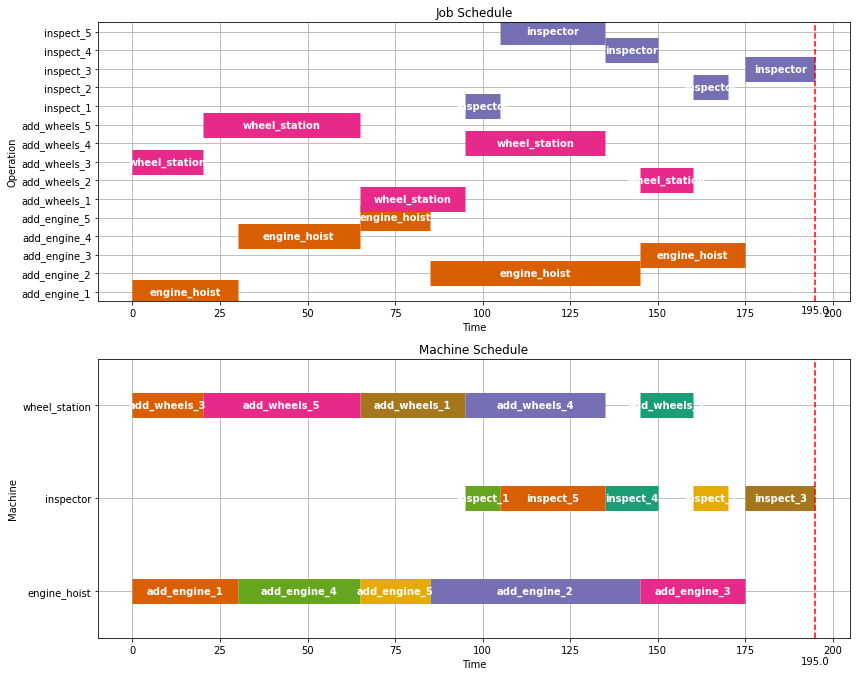

In [52]:
if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
    schedule = []
    for i, job in enumerate(jobs):
        for j, op in enumerate(job):
            schedule.append(
                {
                    'Operation': op['name'],
                    'Machine': op['machine'],
                    'Start': solver.Value(all_tasks[i, j].start),
                    'Duration': op['duration'],
                    'Finish': solver.Value(all_tasks[i, j].end)
                }
            )

    gantt_chart(schedule)    
else:
    print('No solution found.')

---

- More tutorials can be found [here](https://github.com/meiyi1986/tutorials).
- [Yi Mei's homepage](https://meiyi1986.github.io/)